# Binomial Trading
---

In this notebook, I explore (in a faily shallow manner) a trading system that assumes market trades can be modeled by a binomial distribution. The goal is not to design a trading system to be used for active trading. Instead, it is to gain insight into the possible risk of loosing and winning and to shape a trader's expectations.

The idea comes from [a video of George Gammon](https://twitter.com/GeorgeGammon/status/1780331702751298001) where he applies the ideas from blackjack to sketch an early version of a short-to-midterm trading strategy. Sufficient number of competent sources explaining the binomial distributions and its uses exist so I will not attempt to repeat any here. In terms of profit and loss, within this framework, a positive PnL can come from one of two sources:

1. The probability of winning a bet being higher than loosing it.
2. Gains from winning bets being higher than looses from loosing bets.

I explore the system after I initialize the environment and define some functions; feel free to skip the code.

## env
---

In [583]:
import numpy as np
import scipy.stats as ss

In [23]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [585]:
import joblib

memory = joblib.Memory('./.cache', verbose=0)
# memory.clear(warn=False)

In [24]:
import warnings
warnings.filterwarnings('ignore')

## lib
---

In [454]:
def binom_calc(n, k, p):
    '''
    Args:
        n: Number of trials.
        k: Num of successes.
        p: Probability of success on each trial.
    '''

    print(f'Binomial   prob    P(X=k)     {ss.binom.pmf(k=k, n=n, p=p):.5f}    [win/loose k bets]')
    print(f'Cumulative prob    P(X < k)   {ss.binom.cdf(k=k - 1, n=n, p=p):.5f}    [loose k-1 bets]')
    print(f'Cumulative prob    P(X <= k)  {ss.binom.cdf(k=k, n=n, p=p):.5f}    [loose k bets]')
    print(f'Cumulative prob    P(X > k)   {ss.binom.cdf(k=n, n=n, p=p) - ss.binom.cdf(k=k, n=n, p=p):.5f}    [win k-1 bets]')
    print(f'Cumulative prob    P(X >= k)  {ss.binom.cdf(k=n, n=n, p=p) - ss.binom.cdf(k=k - 1, n=n, p=p):.5f}    [win k bets]')

In [586]:
@memory.cache
def comp_binom_loss(p, N):
    return np.array([ss.binom.cdf(k=n // 2 - 1, n=n, p=p) for n in N])

@memory.cache
def comp_binom_gain(p, N):
    return np.array([ss.binom.cdf(k=n, n=n, p=p) - ss.binom.cdf(k=n // 2, n=n, p=p) for n in N])

In [614]:
def plot_binom(n01=10, n02=1000, p=0.5, do_log_scale=True, hspace=0.01, wspace=0.02, top=0.1, figsize=(6,4)):
    def plot(ax, x, y, xlabel, ylabel, title):
        ax.plot(x, y, c='k')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if do_log_scale:
            ax.set_xscale('log')
            ax.set_xlim(n01 - 1, n02 + 100)
        else:
            ax.set_xlim(n01 - 10, n02 + 10)
    
    if type(p) is not list:
        p = [p]
    
    N = tuple(range(n01, n02, 2))
    
    fig, axis = plt.subplots(len(p), 2, sharex=True, sharey=True, figsize=figsize, layout='compressed')
    axis = np.array(axis).reshape(len(p), 2)
    
    for (i, p_i) in enumerate(p):
        xlabel = f'Number of trials (n{"; log" if do_log_scale else ""})' if i == len(p) - 1 else None
        
        y = comp_binom_loss(p_i, N)
        title = f'Loosing' if i == 0 else None
        plot(axis[i][0], N, y, xlabel, f'p={p_i}', title)
        
        title = f'Winning' if i == 0 else None
        y = comp_binom_gain(p_i, N)
        plot(axis[i][1], N, y, xlabel, None, title)
    
    plt.suptitle('Cumulative Prob. of Loosing/Winning Half - 1 Bets', fontsize=16)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.tight_layout()
    plt.show()

In [597]:
def plot_binom_perc_returns(n01=10, n02=1000, p=0.5, loss_gain=(1.0, 1.0), do_log_scale=True, hspace=0.05, wspace=0.01, figsize=(6,4)):
    def plot(ax, x, y, xlabel=None, y_label=None, title=None):
        ax.plot(x, y, c='k')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        # ax.text(0.05, 0.95, txt, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        if do_log_scale:
            ax.set_xscale('log')
            ax.set_xlim(n01 - 1, n02 + 100)
        else:
            ax.set_xlim(n01 - 10, n02 + 10)
    
    if type(p) is not list:
        p = [p]
    if type(loss_gain) is not list:
        loss_gain = [loss_gain]
    
    N = tuple(range(n01, n02, 2))
    
    fig, axis = plt.subplots(len(loss_gain), len(p), sharex=True, sharey=True, figsize=figsize, layout='compressed')
    axis = np.array(axis).reshape(len(loss_gain), len(p))
    
    for (i, (loss_i, gain_i)) in enumerate(loss_gain):
        for (j, p_j) in enumerate(p):
            p_loss = comp_binom_loss(p_j, N)
            p_gain = comp_binom_gain(p_j, N)
            
            returns = np.round((p_gain * gain_i * 100) - (p_loss * loss_i * 100), 8)
            
            x_label = f'Number of trials (n{"; log" if do_log_scale else ""})' if i == len(loss_gain) - 1 else None
            y_label = f'loss={loss_i * 100:.0f}%, gain={gain_i * 100:.0f}%' if j == 0 else None
            title = f'p={p_j}' if i == 0 else None
            
            plot(axis[i][j], N, returns, x_label, y_label, title)

    plt.suptitle('Cumulative Percent Returns', fontsize=16)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.show()

In [572]:
def plot_binom_trades(n01=10, n02=1000, p=0.5, loss_gain=(1.0, 1.0), principal=1000, trade_size=10, trade_cost=0, do_log_scale=True, hspace=0.05, wspace=0.01, figsize=(6,4)):
    def plot(ax, x, series_specs, xlabel=None, y_label=None, title=None):
        for s in series_specs:
            ax.plot(x, s['y'], **s['kwargs'])
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend()
        if do_log_scale:
            ax.set_xscale('log')
            ax.set_xlim(n01 - 1, n02 + 100)
        else:
            ax.set_xlim(n01 - 10, n02 + 10)
    
    if type(p) is not list:
        p = [p]
    if type(loss_gain) is not list:
        loss_gain = [loss_gain]
    
    N = tuple(range(n01, n02, 2))
    
    trade_sizes = np.array([trade_size * n / 2.0 for n in N])  # on one side only (i.e., loosing side or winning side)
    trade_costs = np.array([trade_cost * n / 2.0 for n in N])  # ^
    
    fig, axis = plt.subplots(len(loss_gain), len(p), sharex=True, sharey=True, figsize=figsize, layout='compressed')
    axis = np.array(axis).reshape(len(loss_gain), len(p))
    
    for (i, (loss_i, gain_i)) in enumerate(loss_gain):
        for (j, p_j) in enumerate(p):
            p_loss = comp_binom_loss(p_j, N)
            p_gain = comp_binom_gain(p_j, N)
            
            loss = p_loss * loss_i * trade_sizes
            gain = p_gain * gain_i * trade_sizes
            
            pool = (gain - loss) + principal - trade_costs * 2.0
            pool[pool < 0] = 0.0
            
            x_label = f'Number of trials (n{"; log" if do_log_scale else ""})' if i == len(loss_gain) - 1 else None
            y_label = f'loss={loss_i * 100:.0f}%, gain={gain_i * 100:.0f}%' if j == 0 else None
            title = f'p={p_j}' if i == 0 else None
            
            series_specs = [
                {'y':  pool,              'kwargs': {'label': 'pool',  'c': 'k', 'lw': 2}},
                {'y': -loss,              'kwargs': {'label': 'loss',  'c': 'r', 'lw': 1, 'ls': 'dashed'}},
                {'y':  gain,              'kwargs': {'label': 'gain',  'c': 'g', 'lw': 1, 'ls': 'dashdot'}},
                {'y':  trade_costs * 2.0, 'kwargs': {'label': 'costs', 'c': 'b', 'lw': 1, 'ls': 'dotted'}}
            ]
            
            plot(axis[i][j], N, series_specs, x_label, y_label, title)
    
    plt.suptitle(f'Cumulative Profit and Loss (principal={principal}; trade-size={trade_size}; trade-cost={trade_cost})', fontsize=16)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.show()

## Sanity Check
---

First, a quick run of a basic binomial calculator to ensure correctness:

In [616]:
binom_calc(60, 30, 0.55)

Binomial   prob    P(X=k)     0.07588    [win/loose k bets]
Cumulative prob    P(X < k)   0.18173    [loose k-1 bets]
Cumulative prob    P(X <= k)  0.25761    [loose k bets]
Cumulative prob    P(X > k)   0.74239    [win k-1 bets]
Cumulative prob    P(X >= k)  0.81827    [win k bets]


### Probability of winning/loosing half minus one trades

Let's plot the probability of winning and loosing half minus one bets (`k = n / 2 - 1`) as a function of the probability of success on each trial (`p`) and the number of trials (`n`). Note that the x axis showing the number of trials is log-scaled.

In [617]:
# plot_binom(p=0.55, figsize=(8,4))

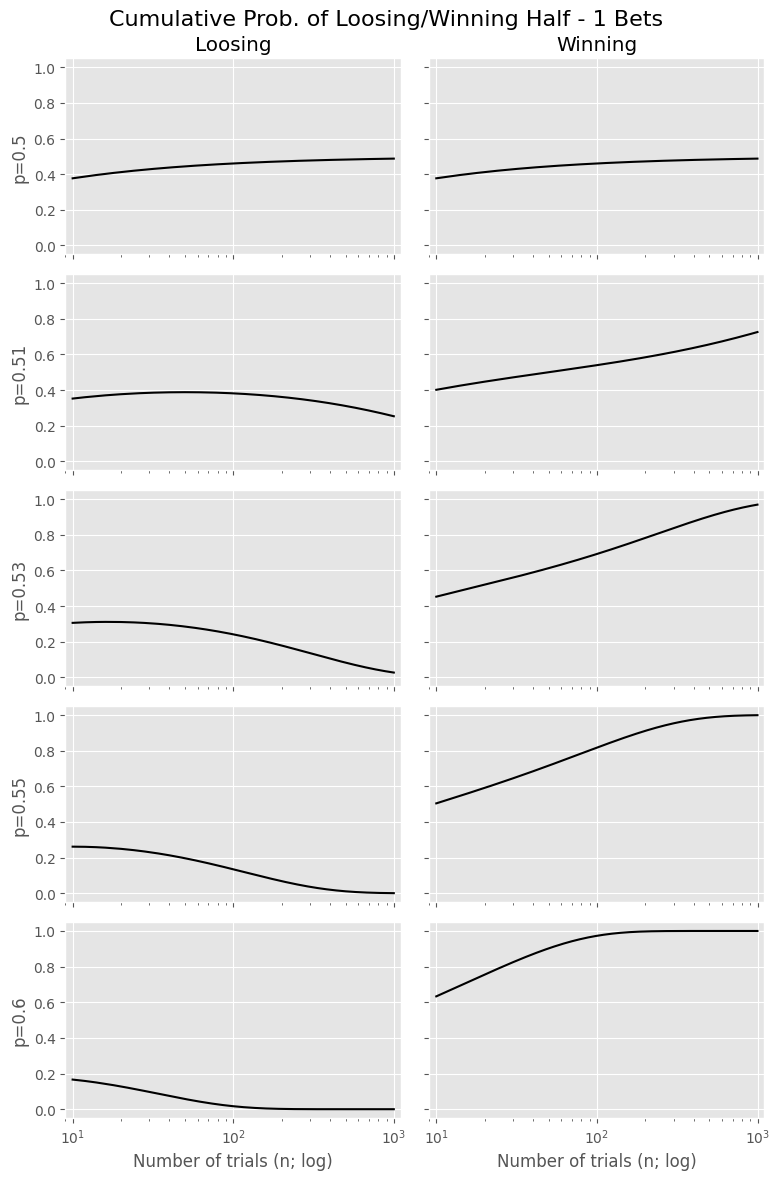

In [619]:
plot_binom(p=[0.5, 0.51, 0.53, 0.55, 0.60], figsize=(8, 12))

George mentions that he hopes to tilt the scales in favor of winning bets by moving the `p` parameter above 0.5 with the review of fundamentals, assesing the current market conditions, etc. He subsequently focuses on an example level of 0.55. At that `p`, the cumulative probability of loosing half minus one trades starts at about 0.26 for ten trades, slides to about 0.13 at 100 trades, and drops to near 0 at a 1,000 trades -- the house always wins.

The remainder of this notebook will combine the cumulative probabilities of loosing and winning half minus one of bets to estiamte the performance of a trading strategy.

### Assymetric Trades

The other ace up George's sleeve in his fight against high frequency traders and market makers is going for assymetrical trades, i.e., those that would pay out more if they won than if they lost. Below, I briefly explore the effect of that assymetry by assuming that every loosing bet looses 100% of the investment, but a winning bet has between 100% and 150% of payout (in 10% increments).

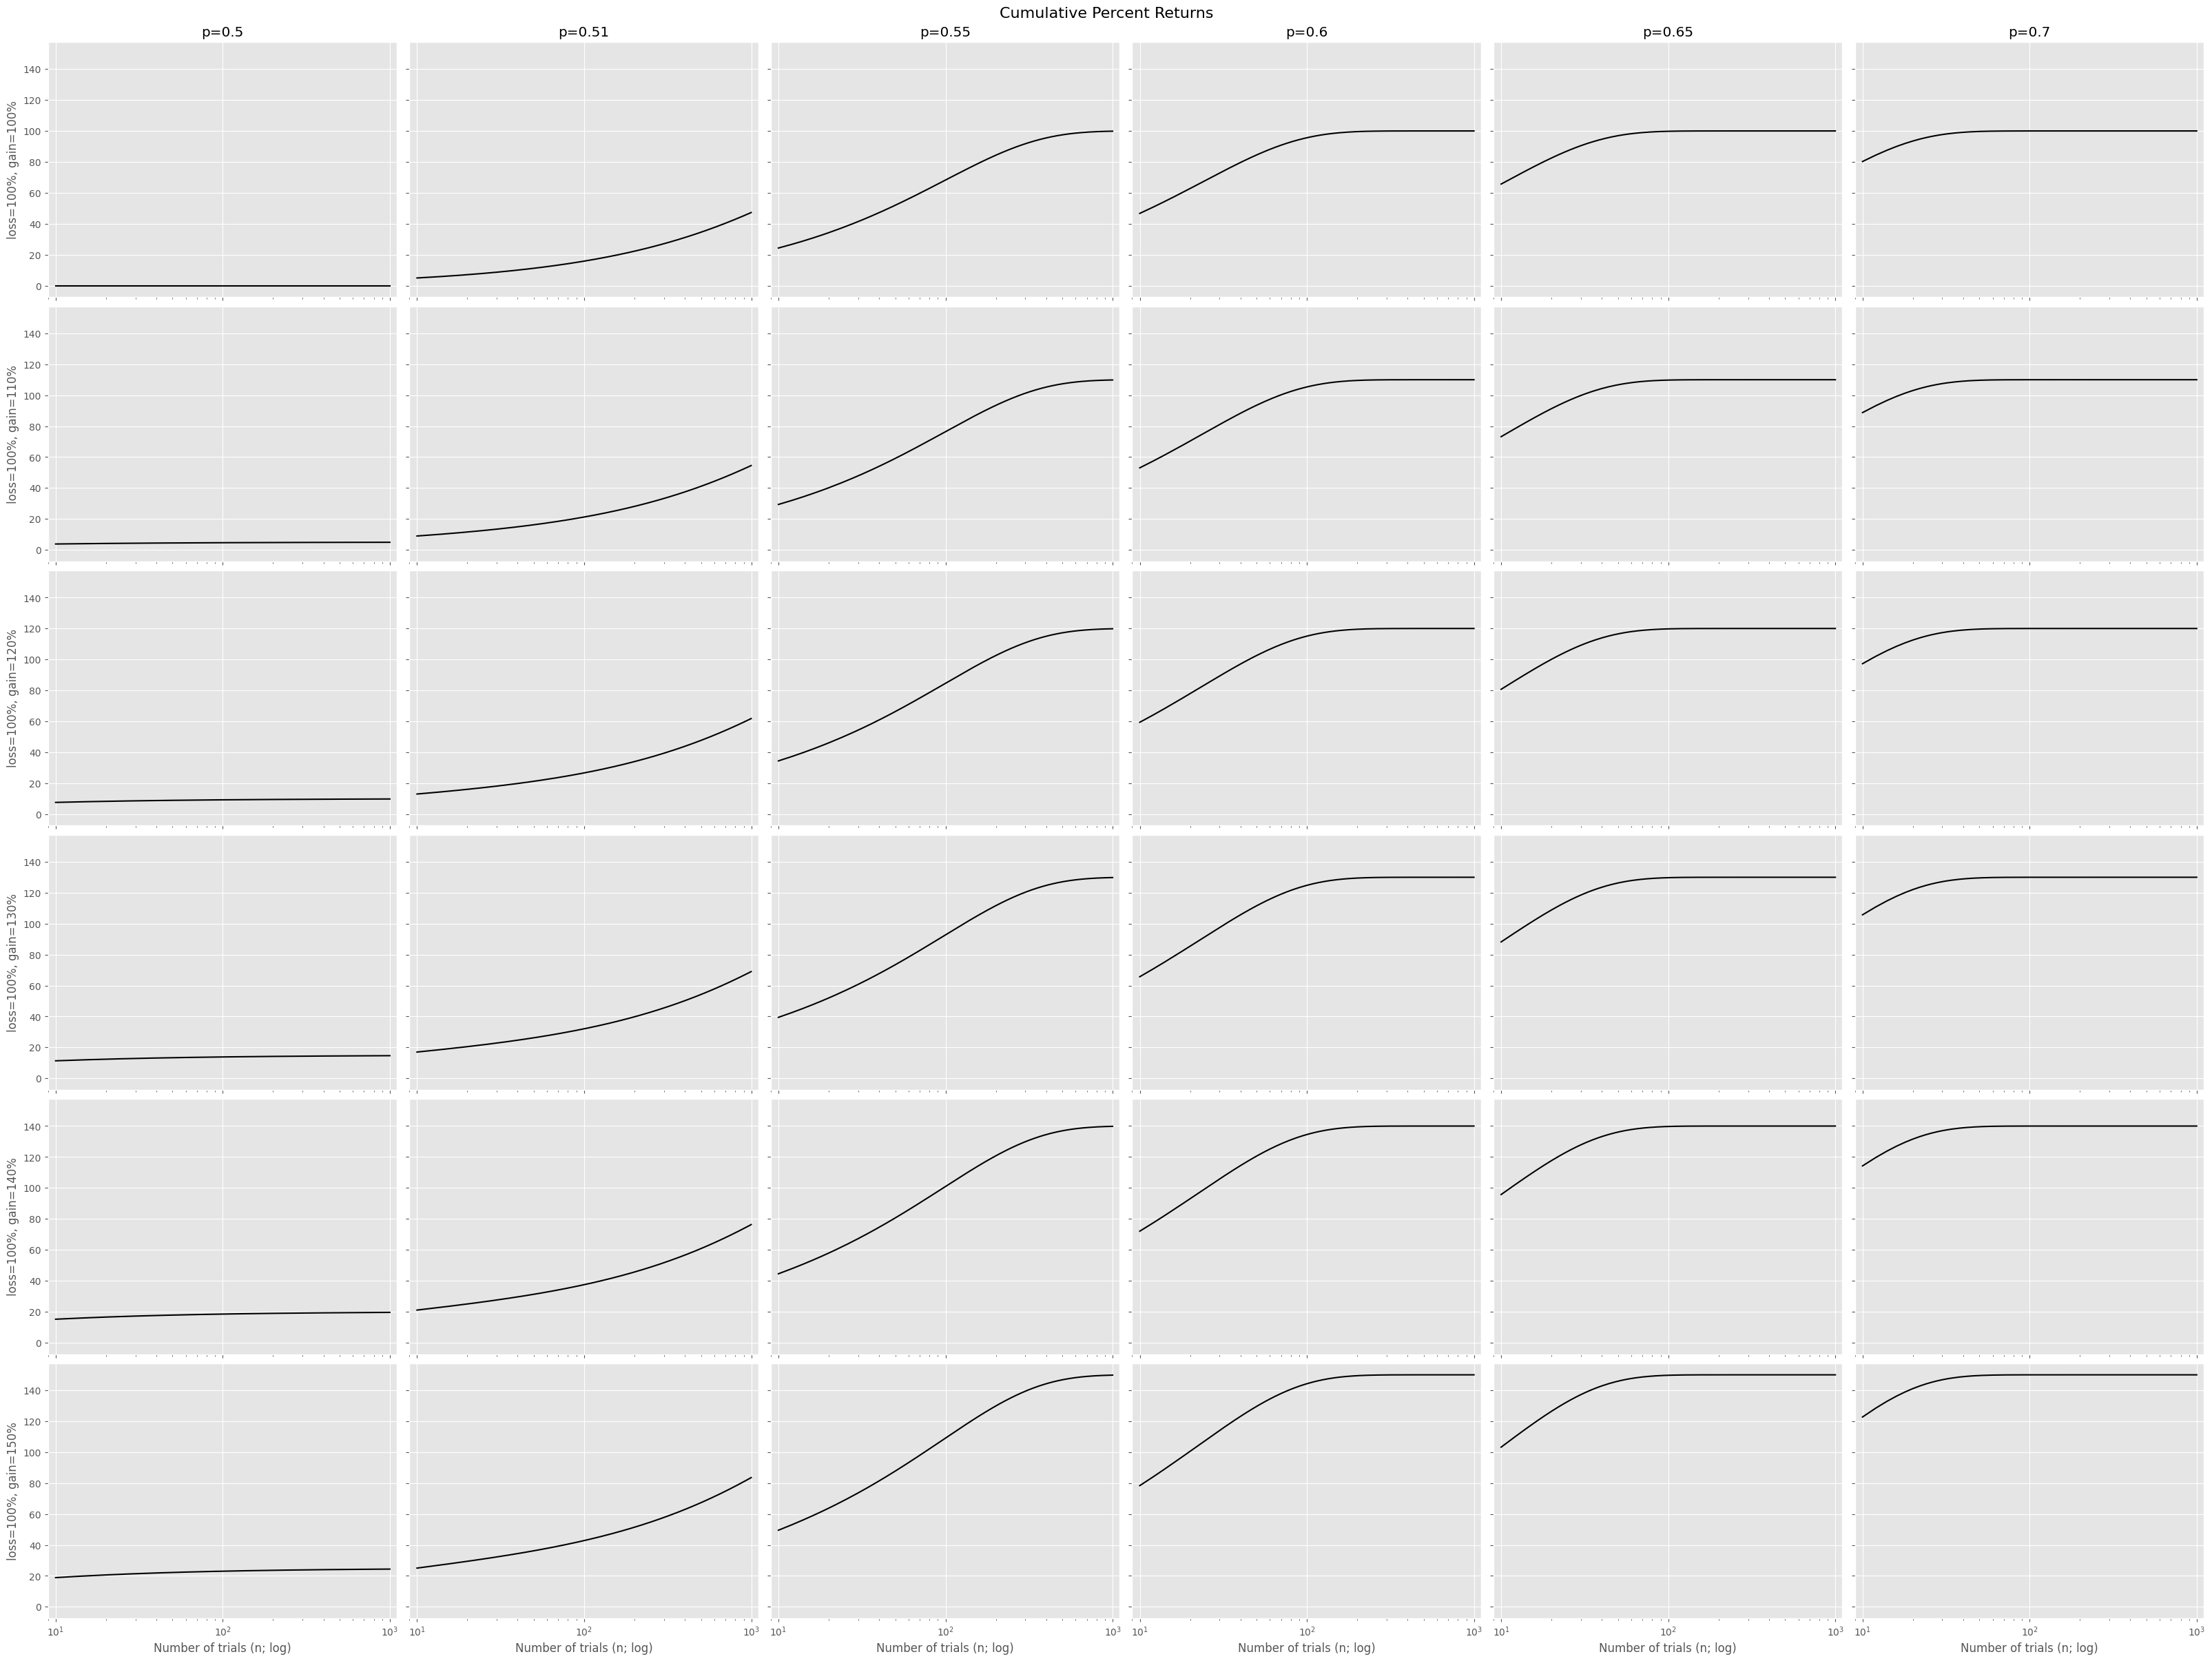

In [623]:
plot_binom_perc_returns(p=[0.50, 0.51, 0.55, 0.60, 0.65, 0.70], loss_gain=[(1.0, 1.0), (1.0, 1.1), (1.0, 1.2), (1.0, 1.3), (1.0, 1.4), (1.0, 1.5)], figsize=(32,24))

As shown in the first column of the graph above, at chance level, identifying assymetric trades results in the expected payout (e.g., around 20% in the last row, i.e., one in five trades is a hit) and the number of trials doesn't matter much. The only way to capture more profits is by increasing `p`. However, because we assume we loose all investment on loosing bets, we cannot go over our maximum gain (e.g., 150% in the last row) irrespective of the number of trials. What making `p` higher does is brings us closer to our maximum payout faster by requiring fewer trades. For example, at `p=0.6` we get near the maximum payout already at 100 trades, while at `p=0.55` we'd need to execute around 400 trades.

### Dollar Amounts

To finish up, let's put dollar amounts on these experiments. Let's look at a few isolated examples to make sure the model works and we understand how changing the parameters affects the outcome. If our investment pool is \\$1,000 and we are making symmetric trades of \\$10 at chance level with no trading costs, as the number of trials increases, so do our gains. However, those gains are offest by symmetrical losses. In other words, we are wasting time. Or visually:

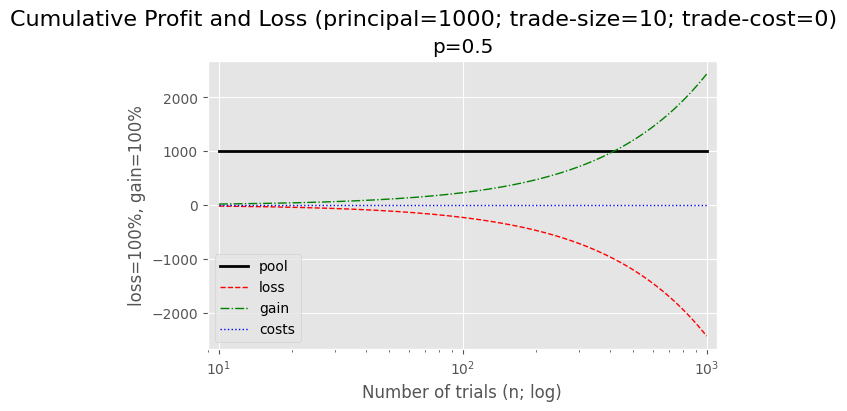

In [632]:
plot_binom_trades(p=[0.5], loss_gain=[(1.0, 1.0)], figsize=(6,4))

If we assume \\$0.65 of trading cost (around the price of a single option trade at most brokerages), predictably, we will be loosing money:

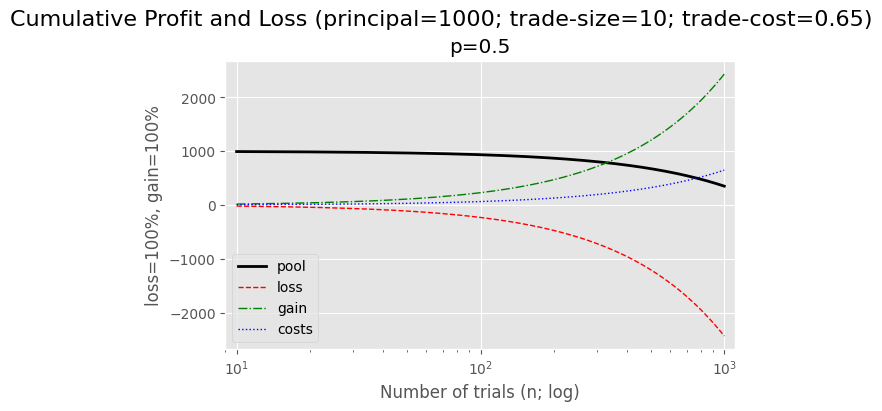

In [634]:
plot_binom_trades(p=[0.5], loss_gain=[(1.0, 1.0)], trade_cost=0.65, figsize=(6,4))

If we lift `p` slightly, we expect to make money only after 100 or so trades, but even then it looks like a painful process that probably isn't worth the hussle:

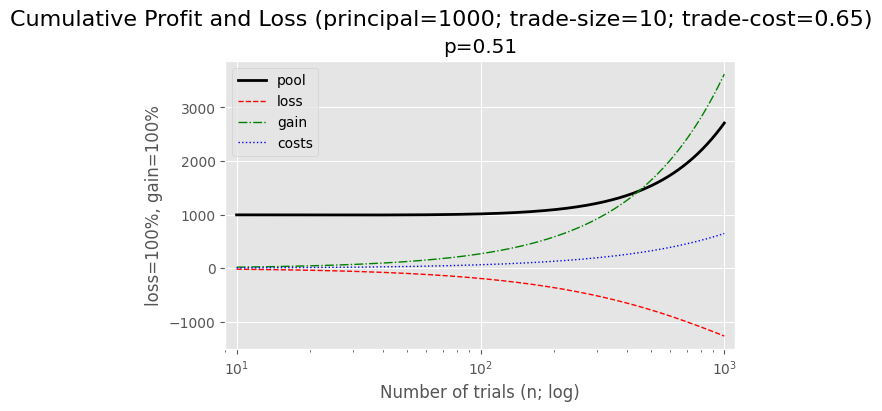

In [635]:
plot_binom_trades(p=[0.51], loss_gain=[(1.0, 1.0)], trade_cost=0.65, figsize=(6,4))

If we make our trades assymetric (100% loss but 150% gain), our projected profit grows faster, but we still need about 400 trades to double our initial investment of \\$1,000. Furthermore, after a whooping 1,000 trades, we can expect to 4.5x our money.

In [636]:
plot_binom_trades(p=[0.51], loss_gain=[(1.0, 1.5)], trade_cost=0.65, figsize=(6,4))

Brining the probability of winning a single bet to 0.55 shortens the time to double out investment by over a half to under 200 trades. At 1,000 trades, we'd expect to nearly 8x our money.

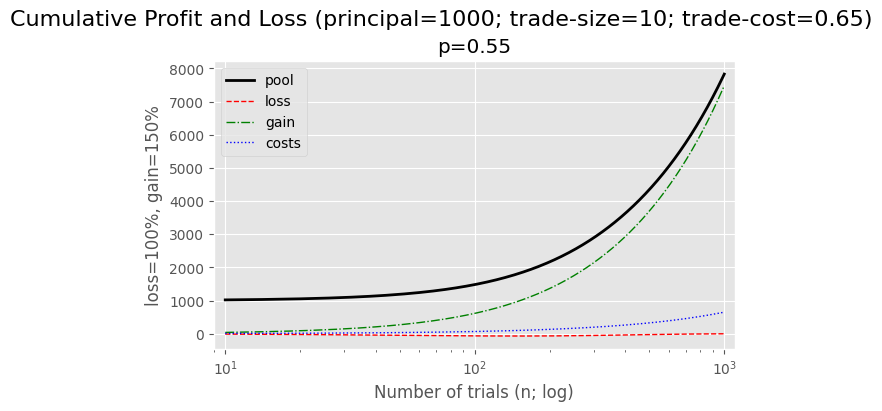

In [637]:
plot_binom_trades(p=[0.55], loss_gain=[(1.0, 1.5)], trade_cost=0.65, figsize=(6,4))

Let's look at a lattice plot to compare a number of different conditions like the ones above:

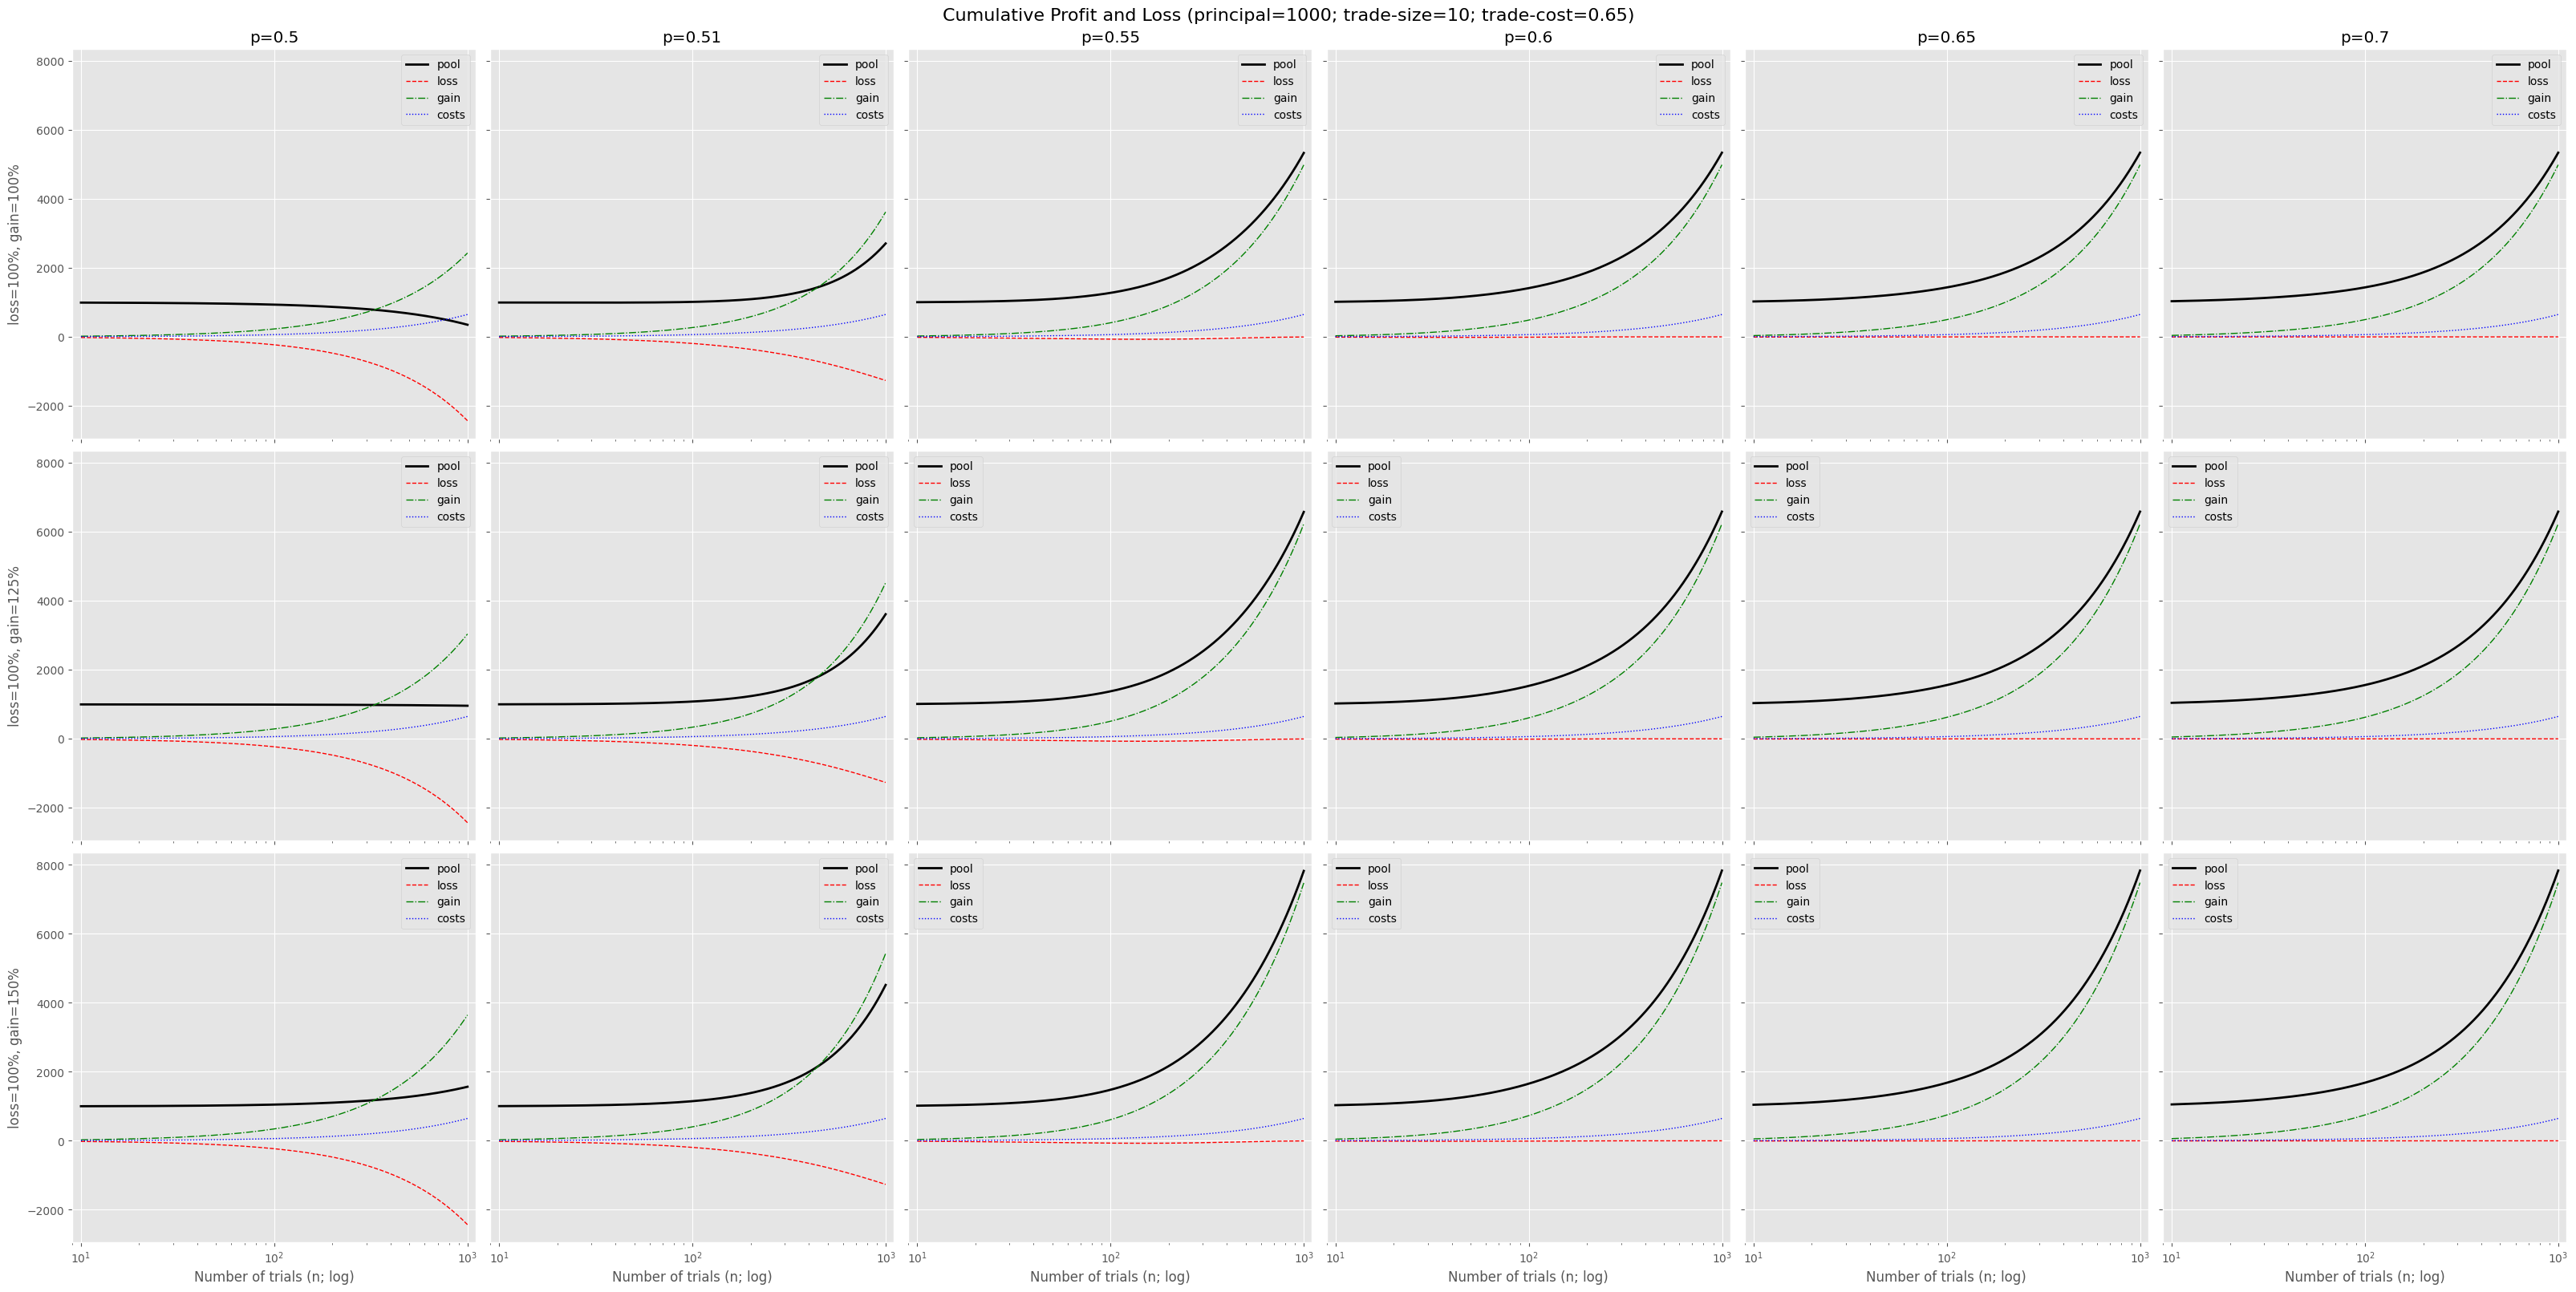

In [640]:
plot_binom_trades(p=[0.5, 0.51, 0.55, 0.6, 0.65, 0.7], loss_gain=[(1.0, 1.0), (1.0, 1.25), (1.0, 1.5)], trade_cost=0.65, figsize=(32,16))

One interesting observation is that at `p=0.55` (or actually already below it), total loss (the red line) is almost flat at zero.

Finally, let's assume a larger initial investment of \\$100,000 and a larger trade size of \\$3,000 to get back in line with George's video:

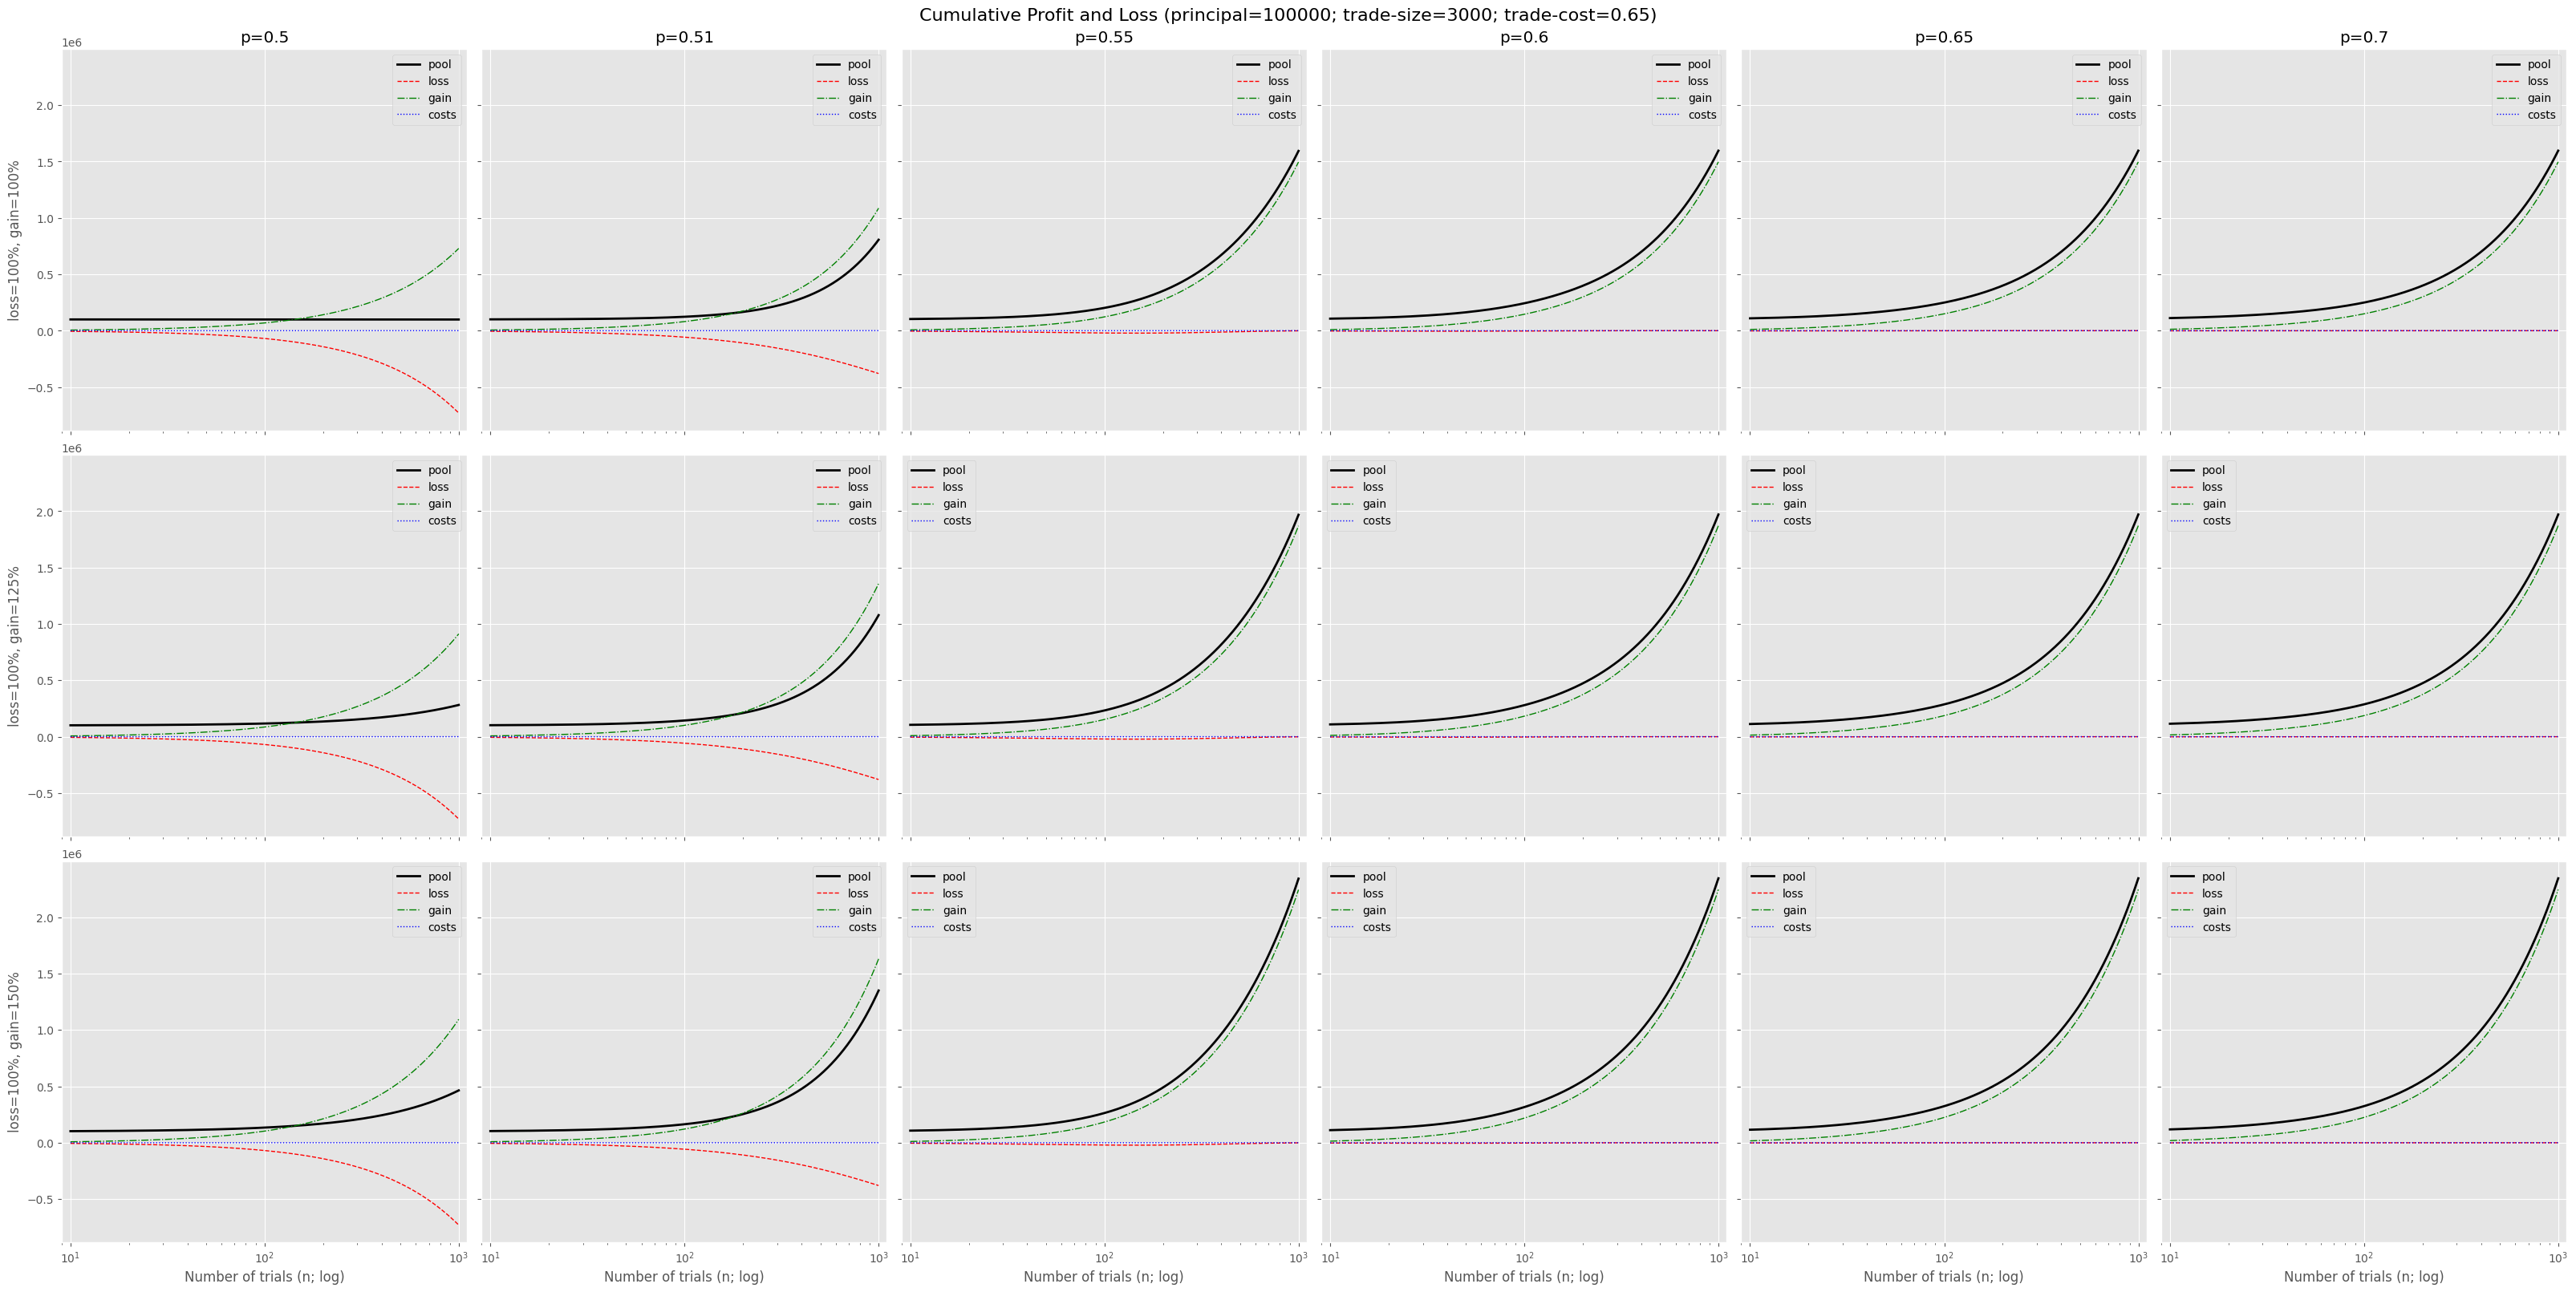

In [643]:
plot_binom_trades(p=[0.5, 0.51, 0.55, 0.6, 0.65, 0.7], loss_gain=[(1.0, 1.0), (1.0, 1.25), (1.0, 1.5)], principal=100_000, trade_size=3_000, trade_cost=0.65, figsize=(32,16))

The y axis gets messed up by the scientific notation, but `1.0` stands for a million dollars. It's interesting to contemplate the number of trades necessary to achieve that level of profit.